# Goodness of fit

## Residual diagnostics using QQ plots

### Structural context of a QSP model

A QSP model comprises three conceptually distinct layers:

1. **Mechanistic (structural) model**
   Ordinary differential equations describing biological, pharmacological, and disease mechanisms.

2. **Observation model**
   Mapping from model states to measured quantities, including scale and transformation (e.g., linear or log scale).

3. **Observation-error model**
   Assumptions on measurement uncertainty, including error structure (additive, proportional, or combined) and distributional form.

---

### Role of the QQ plot in QSP

> **QQ plots of standardized residuals are used to assess whether the empirical distribution of residuals is compatible with the assumed observation-error model (e.g., normality and additivity or proportionality of noise).**

They diagnose the **observation and error layers** of the QSP model and are interpreted **in combination with other goodness-of-fit (GOF) metrics**. QQ plots are not used to assess the validity of the mechanistic model or predictive performance.

---

## Computation of standardized residuals for QQ plots

### When an explicit observation-error model is available (recommended)

1. **Compute raw residuals**
   For each matched observation–prediction pair $$((x_i, y_i))$$:
   $$
   r_i = x_i - y_i
   $$

2. **Derive residual standard deviation**
   The standard deviation (\sigma_i) is obtained from the **observation-error model specified during calibration**, with error parameters estimated jointly with (or fixed alongside) the mechanistic model. Typical forms include:

   * **Additive error:** $$(\sigma_i = \sigma)$$
   * **Proportional error:** $$(\sigma_i = \sigma, y_i)$$
   * **Combined error:**
     $$
     \sigma_i = \sqrt{\sigma_{\text{add}}^2 + (\sigma_{\text{prop}} y_i)^2}
     $$

3. **Standardize residuals**
   $$
   r_i^{*} = \frac{r_i}{\sigma_i}
   $$

4. **Construct QQ plots**
   Standardized residuals were pooled across comparable observations and used to construct QQ plots against a** standard normal distribution**.

> Residual standard deviations were obtained from the calibrated observation-error model and were not estimated empirically from residuals.

---

### If no explicit observation-error model is available

When an explicit observation-error model has not been specified or calibrated, standardized residuals cannot be derived from model-based error parameters. In this case, an **empirical standardization** may be used for **exploratory diagnostics only**.

1. **Compute raw residuals**
   $$
   r_i = x_i - y_i
   $$

2. **Estimate a global residual scale**
   $$
   \sigma = \mathrm{SD}(r_i)
   $$

3. **Standardize residuals**
   $$
   r_i^{*} = \frac{r_i}{\sigma}
   $$

4. **Construct QQ plots**
   Empirically standardized residuals were used to construct QQ plots against a standard normal distribution.

#### Important caveats

* Assumes homoscedasticity and independence of residuals.
* Mixes measurement noise and structural mismatch.
* Deviations from normality cannot be uniquely attributed to the observation-error model.
* Results should be interpreted as **qualitative and exploratory**.

Recommended wording:

> *“In the absence of an explicit observation-error model, residuals were empirically standardized and used for exploratory QQ plot diagnostics only.”*

---

## Interpretation of QQ plot shapes in QSP

| QQ plot shape            | Typical interpretation in QSP                                |
| ------------------------ | ------------------------------------------------------------ |
| Near-linear              | Observation-error model broadly compatible                   |
| S-shape (heavy tails)    | Unmodeled variability, outliers, wrong noise distribution    |
| Systematic curvature     | Mismatch in observation mapping or missing dynamics          |
| Skewed                   | Wrong scale, censoring (e.g., LLOQ), or systematic bias      |
| Tight center, wide tails | Nonlinear amplification or extrapolation regions             |
| Clustered / step-like    | Sparse data, pooling across subjects, identifiability limits |

Moderate deviations from the diagonal are **expected** in nonlinear mechanistic models and should prompt investigation rather than rejection.

---

## QQ plots within the GOF ecosystem

Residual QQ plots are interpreted **alongside complementary GOF diagnostics**, including:

* Observed vs predicted plots
* Residuals vs time or predictions
* Prediction interval or envelope coverage
* Sensitivity and uncertainty analyses
* External or prospective predictions (when available)

> **QQ plots provide qualitative diagnostic insight and do not constitute a standalone GOF metric.**

---

## What QQ plots are not a stand-in for

QQ plots cannot replace:

* Overall goodness-of-fit of the mechanistic model
* Predictive performance or accuracy
* Model validation or qualification
* Biological correctness
* Decision robustness

A good QQ plot does **not** validate a QSP model, and a poor QQ plot does **not** invalidate it.

---

### One-sentence takeaway

> **In QSP, residual QQ plots are supporting diagnostics used to assess compatibility of residual distribution assumptions within the observation-error model and must be interpreted together with other GOF metrics, not in isolation.**

In [1]:
# Jinko specifics imports & initialization
# Please fold this section and do not change
import jinko_helpers as jinko


# This function ensures that authentication is correct
# It it also possible to override the base url by passing baseUrl=...
# If everything is well setup, it should print "Authentication successful"
jinko.initialize()

In [2]:
# Cookbook specifics imports

import io
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import sklearn
import isodate
import numpy as np
from scipy.stats import linregress
import statsmodels.api as sm

In [ ]:
trial_sid = "tr-0C5Y-ErUp" # Atopic dermatitis project / Nova Demo organization
timeseries_ids = ["easiPercImprovement"]
arm_names = ["Emollient", "Emollient_and_Moderate_TCS"]


# Choose a specific revision. By default we return the last version
revision = None
# Choose a specific label. By default we return the last version
label = "cookbook"
response = jinko.get_project_item(sid=trial_sid, revision=revision, label=label)
trial_core_item_id, trial_snapshot_id = (
    response["coreId"]["id"],
    response["coreId"]["snapshotId"],
)


response = jinko.make_request(
    f"/core/v2/result_manager/trial/{trial_core_item_id}/snapshots/{trial_snapshot_id}/timeseries/download",
    method="POST",
    json={"timeseries": {ts: arm_names for ts in timeseries_ids}},
)

archive = zipfile.ZipFile(io.BytesIO(response.content))
filename = archive.namelist()[0]

simulated_df = (
    pd.read_csv(io.StringIO(archive.read(filename).decode("utf-8")))
    .rename(
        columns={
            "Patient Id": "patientId",
            "Arm": "protocol_arm",
            "Value": "value",
            "Time": "time",
        }
    )
    .drop_duplicates()
)
seconds_per_day = 86400
simulated_df["time"] = simulated_df["time"].apply(lambda t: t / seconds_per_day)

In [4]:
data_table_sid = "dt-F6xO-XpBe"

data_table_project_item = jinko.get_project_item(sid=data_table_sid, revision=2)

data_table_core_item_id = data_table_project_item["coreId"]["id"]
data_table_snapshot_id = data_table_project_item["coreId"]["snapshotId"]

response = jinko.make_request(
    path=f"/core/v2/data_table_manager/data_table/{data_table_core_item_id}/snapshots/{data_table_snapshot_id}/export",
    method="POST",
)
experimental_df = pd.DataFrame(response.json())
experimental_df["time"] = experimental_df["time"].apply(
    lambda x: isodate.parse_duration(x).total_seconds() / seconds_per_day
)

Output: easiPercImprovement
  Arm: Emollient
    RMSE = 1.01e+00, R2 = 1, CCC = 1
    MAE = 8.02e-01


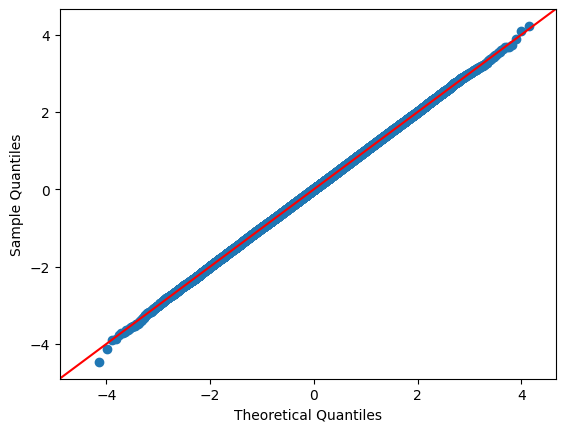

  Arm: Emollient_and_Moderate_TCS
    RMSE = 1.01e+00, R2 = 1, CCC = 1
    MAE = 8.02e-01


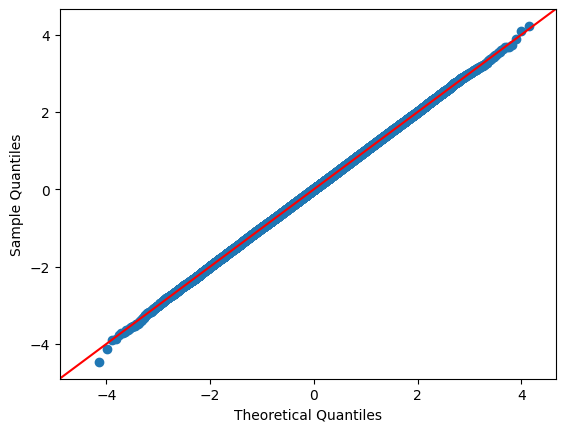

In [6]:
experimental_df = experimental_df.rename(columns={"value": "experimental"})
simulated_df = simulated_df.rename(columns={"value": "simulated"})
aggregated = pd.merge(
    experimental_df,
    simulated_df,
    on=["patientId", "Descriptor", "protocol_arm", "time"],
)
for output in timeseries_ids:
  print(f"Output: {output}")
  per_output_df = aggregated[aggregated["Descriptor"] == output]
  for arm in arm_names:
      print(f"  Arm: {arm}")
      filter_df = per_output_df[per_output_df["protocol_arm"] == arm]
      y_true = per_output_df["experimental"].to_numpy()
      y_pred = per_output_df["simulated"].to_numpy()
      residual = y_true - y_pred
      rho = np.corrcoef(y_true, y_pred)[0, 1]
      ccc = 2 * rho * np.std(y_true) * np.std(y_pred) / (np.var(y_true) + np.var(y_pred) + np.mean(residual)**2)
      rmse = np.sqrt(np.mean(residual**2))
      reg = linregress(x=y_true, y=y_pred)
      mae = sklearn.metrics.mean_absolute_error(y_true=y_true, y_pred=y_pred)
      print(f"    RMSE = {rmse:.2e}, R2 = {reg.rvalue**2:.2g}, CCC = {ccc:.2g}")
      print(f"    MAE = {mae:.2e}")
      standardized_residual = residual if rmse <= 0 else residual / rmse
      sm.qqplot(data = standardized_residual, line="45")
      plt.show()